In [1]:
from q1_vae import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

#from q1_train_vae import *
#from q1_vae import *
device = 'cuda:3'

/tmp/ipykernel_2857912/359786274.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = torch.load('vea_saved/loss_vea.pt')


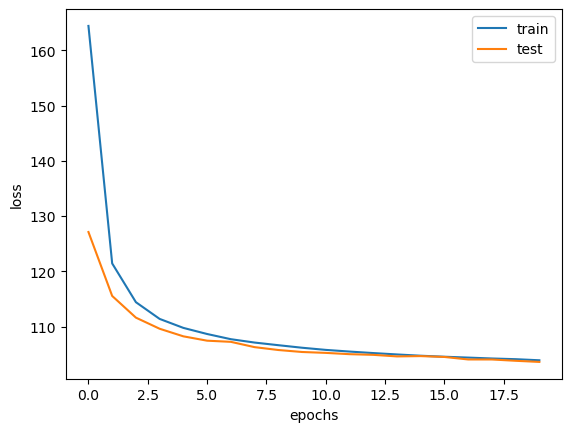

In [2]:
losses = torch.load('vea_saved/loss_vea.pt')
plt.plot(losses['train_losses'],label='train')
plt.plot(losses['val_losses'],label='test')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
#plt.savefig('./vea_saved/results/loss.png',format='png')
plt.show()

In [3]:
losses['train_losses'][-1]

103.90416761067708

In [5]:
losses['val_losses'][-1]

103.60612307128906

# VEA

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
chkpt = torch.load('./vea_saved/model.pt',map_location='cpu')
model.load_state_dict(chkpt)
model.to(device)


/tmp/ipykernel_2857912/1767204950.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load('./vea_saved/model.pt',map_location='cpu')


VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

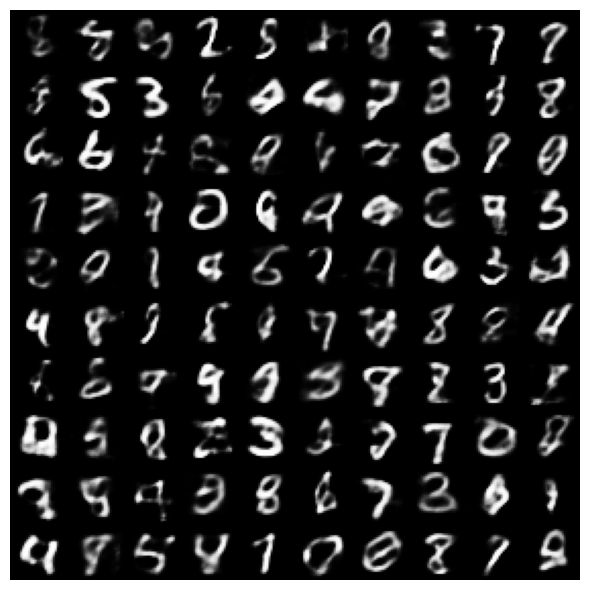

In [7]:
from torchvision.utils import make_grid

with torch.no_grad():
    n_samples = 10*10
    z = torch.randn(n_samples, 20).to(device)
    generated = model.decode(z).view(-1, 28, 28)



imgs = generated.unsqueeze(1)

grid = make_grid(imgs, nrow=10, padding=0, normalize=False)

np_grid = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(np_grid.squeeze(), cmap='gray')  
plt.axis('off')
plt.tight_layout()
#plt.savefig('./vea_saved/results/samples.png',format='png')
plt.show()

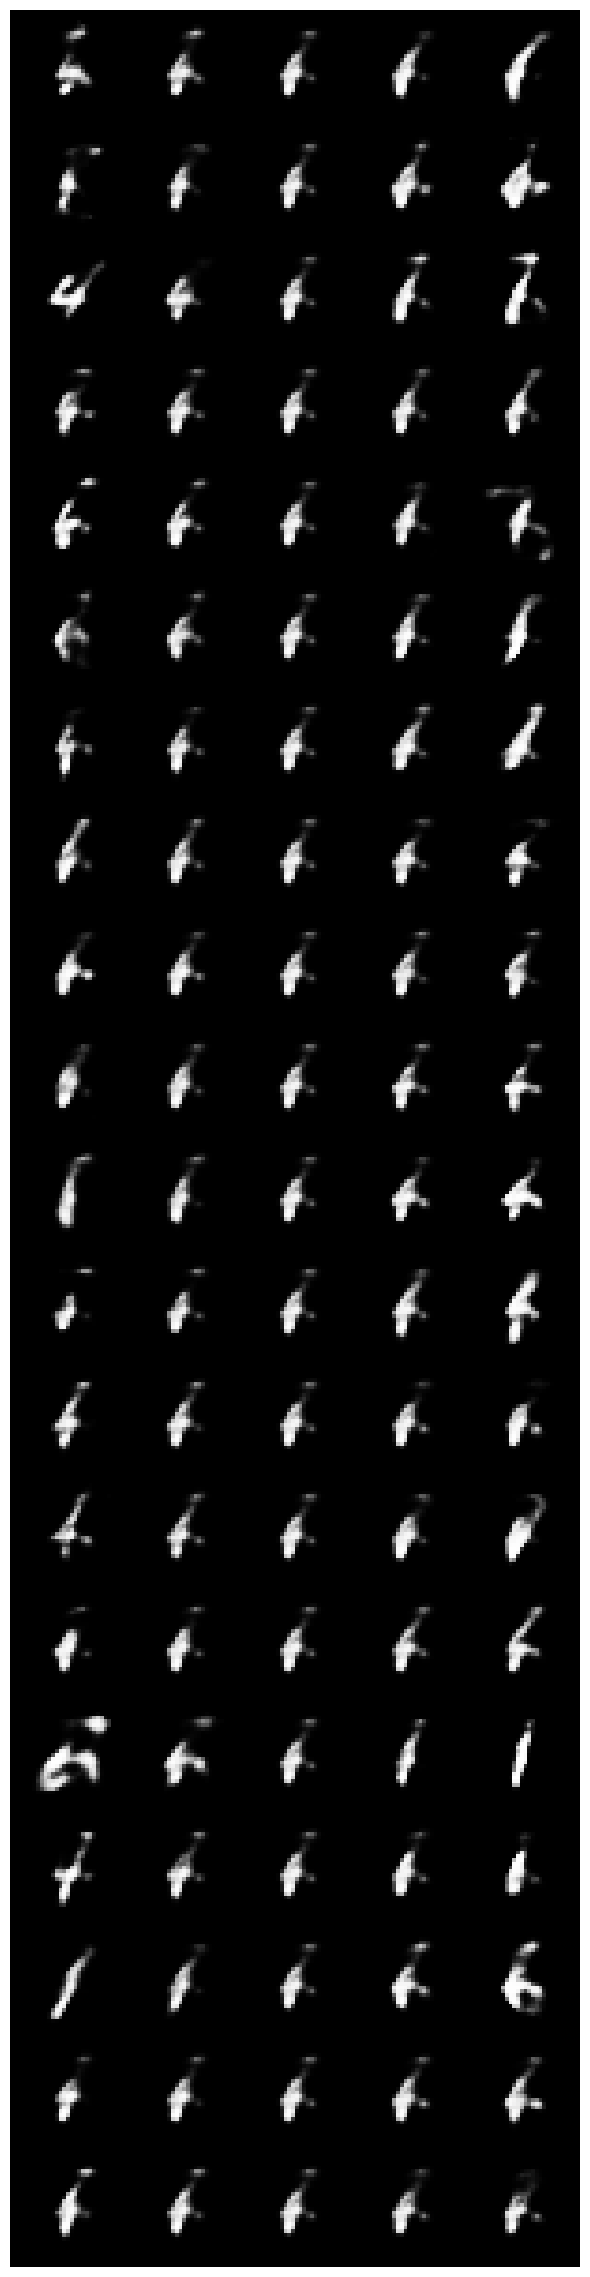

In [16]:
z0 = torch.randn(20, device=device)

deltas = torch.linspace(-2, 2, 5, device=device)

offsets = torch.eye(20, device=device)[:, None, :] * deltas[None, :, None]      

z = z0.repeat(20, 5, 1) + offsets      

with torch.no_grad():
    recon = model.decode(z.view(-1, 20))       

grid = make_grid(recon, nrow=5, padding=2, normalize=True)
img = grid.permute(1, 2, 0).cpu().numpy()

plt.imshow(img.squeeze(), cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()


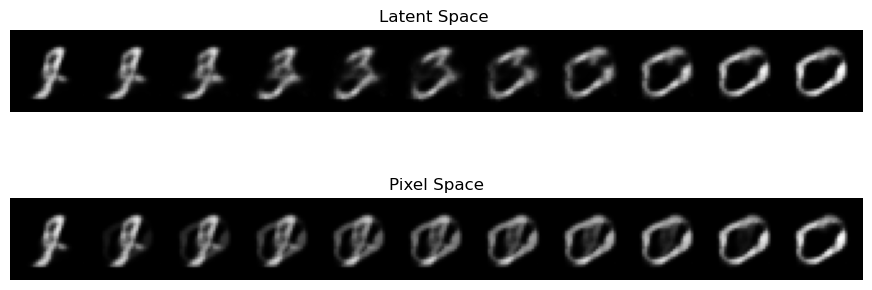

In [44]:
with torch.no_grad():
    z0 = torch.randn(1, 20, device=device)
    z1 = torch.randn(1, 20, device=device)

alphas = torch.linspace(0, 1, steps=11, device=device)  

latents = torch.stack([a * z0 + (1 - a) * z1 for a in alphas], dim=0)   
dec_latent = model.decode(latents).view(-1, 1, 28, 28)                  
grid_latent = make_grid(dec_latent, nrow=11, padding=2, normalize=True)


with torch.no_grad():
    x0 = model.decode(z0).view(1, 1, 28, 28)
    x1 = model.decode(z1).view(1, 1, 28, 28)
pixels = torch.stack([a * x0 + (1 - a) * x1 for a in alphas], dim=0).view(-1, 1, 28, 28)
grid_pixel = make_grid(pixels, nrow=11, padding=2, normalize=True)

fig, axes = plt.subplots(2, 1, figsize=(11, 4))

axes[0].imshow(grid_latent.detach().cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axes[0].set_title('Latent Space ')
axes[0].axis('off')
axes[0].set_xticks(alphas.cpu())
axes[0].set_xticklabels(alphas, rotation=45)

axes[1].imshow(grid_pixel.detach().cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axes[1].set_title('Pixel Space')
axes[1].axis('off')
axes[1].set_xticks(alphas.cpu())
axes[1].set_xticklabels(alphas.cpu(), rotation=45)

plt.savefig('./vea_saved/results/interpolating.png',format='png')



plt.show()